In [1]:
import pandas
import json

In [2]:
with open('roll_calibration.json') as f:
    roll_data = json.load(f)

In [3]:
roll_readings = []
for rec in roll_data['roll_readings']:
    x, y, z = rec['mag_xyz']
    roll_readings.append({
        'pitch': rec['pitch'],
        'roll': rec['roll'],
        'x': x, 'y': y, 'z': z,
    })

In [4]:
roll_df = pandas.DataFrame.from_records(roll_readings)
roll_df.head()

,pitch,roll,x,y,z
0,9.840134,-7.433393,86,841,4083
1,9.652645,-7.619682,91,852,4059
2,10.755135,-4.912883,54,854,4081
3,11.575489,-7.202539,54,854,4081
4,10.462870,-9.086972,21,898,4074


In [5]:
%matplotlib inline

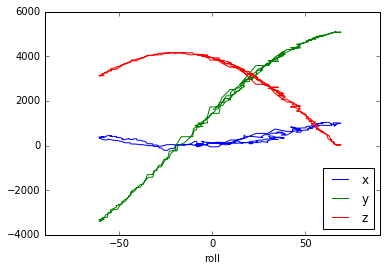

In [6]:
ax = roll_df.plot('roll', 'x')
roll_df.plot('roll', 'y', ax=ax)
roll_df.plot('roll', 'z', ax=ax, xlim=(-90, 90))

The formula for MagY_comp we're using is:

```python
MagY_comp = (MagX*math.sin(roll)*math.sin(pitch)) +\
     (MagY*math.cos(roll)) - (((m * MagZ) + c )*math.sin(roll)*math.cos(pitch)) 
```

In [7]:
roll_data.keys()

dict_keys(['roll_readings', 'offset_Y', 'offset_X', 'range_X', 'range_Y'])

In [8]:
roll_data['offset_X']

-839

Define the function we want to minimise.

`p` is the array of two parameters; leastsq will try to optimise these so that the array it gets back is as close to 0 as possible.

In [9]:
import numpy as np
y_flat = roll_df[(-3 < roll_df.roll) & (roll_df.roll < +3)]['y'].mean()

# Adjust X and Y fields by calibration already got (dance calibration)
MagX = (roll_df.x - roll_data['offset_X']) / roll_data['range_X']
MagY = (roll_df.y - roll_data['offset_Y']) / roll_data['range_Y']
MagY_flat = (y_flat - roll_data['offset_Y']) / roll_data['range_Y']
raw_z = roll_df.z

# Convert pitch and roll to radians for trig functions
roll = roll_df.roll
roll_r = np.radians(roll)
pitch = roll_df.pitch
pitch_r = np.radians(pitch)

def mag_y_comp_residuals(p):
    MagY_comp = (MagX * np.sin(roll_r) * np.sin(pitch_r)) +\
     (MagY * np.cos(roll_r)) - (((p[0] * raw_z) + p[1])* np.sin(roll_r) * np.cos(pitch_r)) 
    return MagY_comp - MagY_flat

Find the best parameters with [leastsq()](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html). If it was successful, `ier` should be an integer from 1 to 4, inclusive.

In [10]:
from scipy.optimize import leastsq
res, ier = leastsq(mag_y_comp_residuals, (1, 1))
assert 1 <= ier <= 4
res

array([ 0.00029669, -0.02104944])

In [11]:
MagZ = (res[0] * raw_z) + res[1]

MagY_comp = (MagX * np.sin(roll_r) * np.sin(pitch_r)) +\
    (MagY * np.cos(roll_r)) - (MagZ * np.sin(roll_r) * np.cos(pitch_r))

In [12]:
import matplotlib.pyplot as plt

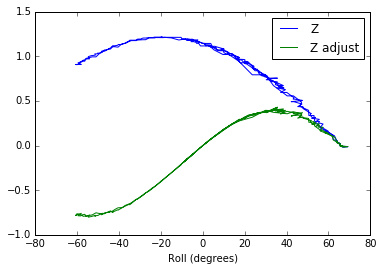

In [13]:
#plt.plot(roll, raw_z, label='Raw Z')
plt.plot(roll, MagZ, label='Z')
plt.plot(roll, MagZ * np.sin(roll_r) * np.cos(pitch_r), label='Z adjust')
plt.xlabel('Roll (degrees)')
plt.legend()

Plot the Y field values and the roll-compensated Y field. The compensated one should be flat, and they should intersect where `roll=0`.

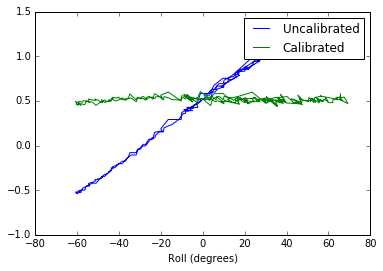

In [14]:
plt.plot(roll, MagY, label='Uncalibrated')
plt.plot(roll, MagY_comp, label='Calibrated')
plt.xlabel('Roll (degrees)')
plt.legend()